# Tutorial 7: Microlearning

**Week 2, Day 3: Microlearning

**By Neuromatch Academy** 

__Content creators:__ Blake Richards, Roman Pogodin, Daniel Levenstein, Colin Bredenberg, Jonathan Cornford

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]

___

# Tutorial Objectives

*Estimated timing of tutorial: [insert estimated duration of whole tutorial in minutes]*

In this tutorial, you will learn about normative models of synaptic plasticity. Normative models of synaptic plasticity are learning rules for parameters in neural networks that have two important features:

  * They optimize global objective functions that define behavioral/perceptual goals for an agent.

  * Unlike learning algorithms like backpropagation, they demonstrate how learning is 'local', i.e. it uses only information that could conceivably be available to a single synapse.

These two features together make such learning algorithms good candidate models for how learning could work in the brain.

In this tutorial we will:

**Tutorial Learning Objectives**
* Relate local plasticity rules to estimates of loss gradients
* Understand the impact of variance and bias in gradient estimators and how they affect performance on training data and generalization
* Implement 2-3 learning rules in toy tasks
* Describe issues with biological plausibility in some learning algorithms, most notably, weight transport

In [1]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: 'Link to the slides'


# Setup

In [2]:
# @title Install dependencies

In [3]:
# @title Import dependencies

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import pdb # we encourage you to use the debugger, rather than print statements!
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import logging

In [4]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions


In [6]:
# @title Helper functions

# The sigmoid activation function
def sigmoid(X):
    """
    Returns the sigmoid function, i.e. 1/(1+exp(-X))
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    toobig = X > 500
    toosmall = X < -500
    Y[toobig] = 500
    Y[toosmall] = -500

    return 1.0 / (1.0 + np.exp(-Y))


# The ReLU activation function
def ReLU(X):
    """
    Returns the ReLU function, i.e. X if X > 0, 0 otherwise
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    neg = X < 0
    Y[neg] = 0

    return Y


# A helper function to add an "always on" unit to the inputs, let's us keep the biases in the weight matrices
def add_bias(inputs):
    """
    Append an "always on" bias unit to some inputs
    """
    return np.append(inputs, np.ones((1, inputs.shape[1])), axis=0)


# Creates a random set of batches, returns an array of indices, one for each batch
def create_batches(rng, batch_size, num_samples):
    """
    For a given number of samples, returns an array of indices of random batches of the specified size.

    If the size of the data is not divisible by the batch size some samples will not be included.
    """

    # determine the total number of batches
    num_batches = int(np.floor(num_samples / batch_size))

    # get the batches (without replacement)
    return rng.choice(np.arange(num_samples), size=(num_batches, batch_size), replace=False)


# Calculate the accuracy of the network on some data
def calculate_accuracy(outputs, targets):
    """
    Calculate the accuracy in categorization of some outputs given some targets.
    """

    # binarize the outputs for an easy calculation
    categories = (outputs == np.tile(outputs.max(axis=0), (10, 1))).astype('float')

    # get the accuracy
    accuracy = np.sum(categories * targets) / targets.shape[1]

    return accuracy * 100.0


def calculate_cosine_similarity(grad_1, grad_2):
    """
    Calculate the cosine similarity between two gradients
    """
    grad_1 = grad_1.flatten()
    grad_2 = grad_2.flatten()
    return np.dot(grad_1, grad_2) / np.sqrt(np.dot(grad_1, grad_1)) / np.sqrt(np.dot(grad_2, grad_2))


def calculate_grad_snr(grad, epsilon=1e-3):
    """
    Calculate the average SNR |mean|/std across all parameters in a gradient update
    """
    return np.mean(np.abs(np.mean(grad, axis=0)) / (np.std(grad, axis=0) + epsilon))


In [7]:
# Load the MNIST dataset, 50K training images, 10K validation, 10K testing
train_set = datasets.MNIST('./', transform=transforms.ToTensor(), train=True, download=True)
test_set = datasets.MNIST('./', transform=transforms.ToTensor(), train=False, download=True)

rng_data = np.random.default_rng(seed=42)
shuffled_train_idx = rng_data.permutation(60000)

full_train_images = train_set.data.numpy().astype(float) / 255
train_images = full_train_images[shuffled_train_idx[:50000]].reshape((-1, 784)).T.copy()
valid_images = full_train_images[shuffled_train_idx[50000:]].reshape((-1, 784)).T.copy()
test_images = (test_set.data.numpy().astype(float) / 255).reshape((-1, 784)).T

full_train_labels = torch.nn.functional.one_hot(train_set.targets, num_classes=10).numpy()
train_labels = full_train_labels[shuffled_train_idx[:50000]].T.copy()
valid_labels = full_train_labels[shuffled_train_idx[50000:]].T.copy()
test_labels = torch.nn.functional.one_hot(test_set.targets, num_classes=10).numpy().T

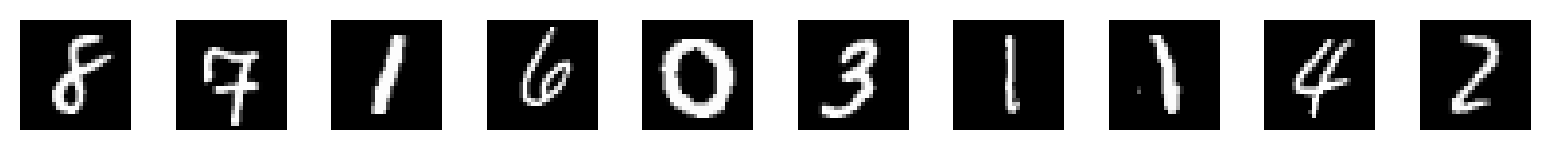

In [8]:
#Plot some example images to make sure everything is loaded in properly
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(train_images[:,c].reshape((28,28)), cmap='gray')
    axs[c].axis("off")
plt.show()

In [9]:
# The main network class
class MLP(object):
    """
    The class for creating and training a two-layer perceptron.
    """

    # The initialization function
    def __init__(self, rng, N=100, sigma=1.0, activation='sigmoid'):
        """
        The initialization function for the MLP.

         - N is the number of hidden units
         - sigma is the SD for initializing the weights
         - activation is the function to use for unit activity, options are 'sigmoid' and 'ReLU'
        """

        # store the variables for easy access
        self.N = N
        self.sigma = sigma
        self.activation = activation

        # initialize the weights
        self.W_h = rng.normal(scale=self.sigma, size=(self.N, 784 + 1))  # input-to-hidden weights & bias
        self.W_y = rng.normal(scale=self.sigma, size=(10, self.N + 1))  # hidden-to-output weights & bias
        self.V = rng.normal(scale=self.sigma, size=(self.N, 10))  # feedback weights

    # The non-linear activation function
    def activate(self, inputs):
        """
        Pass some inputs through the activation function.
        """
        if self.activation == 'sigmoid':
            Y = sigmoid(inputs)
        elif self.activation == 'ReLU':
            Y = ReLU(inputs)
        else:
            raise Exception("Unknown activation function")
        return Y

    # The function for performing a forward pass up through the network during inference
    def inference(self, rng, inputs, W_h=None, W_y=None, noise=0.):
        """
        Recognize inputs, i.e. do a forward pass up through the network. If desired, alternative weights
        can be provided
        """

        # load the current network weights if no weights given
        if W_h is None:
            W_h = self.W_h
        if W_y is None:
            W_y = self.W_y

        # calculate the hidden activities
        hidden = self.activate(np.dot(W_h, add_bias(inputs)))
        if not (noise == 0.):
            hidden += rng.normal(scale=noise, size=hidden.shape)

        # calculate the output activities
        output = self.activate(np.dot(W_y, add_bias(hidden)))

        if not (noise == 0.):
            output += rng.normal(scale=noise, size=output.shape)

        return hidden, output

    # A function for calculating the derivative of the activation function
    def act_deriv(self, activity):
        """
        Calculate the derivative of some activations with respect to the inputs
        """
        if self.activation == 'sigmoid':
            derivative = activity * (1 - activity)
        elif self.activation == 'ReLU':
            derivative = 1.0 * (activity > 1)
        else:
            raise Exception("Unknown activation function")
        return derivative

    def mse_loss_batch(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """

        # do a forward sweep through the network
        if (output is None):
            (hidden, output) = self.inference(rng, inputs, W_h, W_y)
        return np.sum((targets - output) ** 2, axis=0)

    # The function for calculating the mean-squared error loss
    def mse_loss(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """
        return np.mean(self.mse_loss_batch(rng, inputs, targets, W_h=W_h, W_y=W_y, output=output))

    # function for calculating perturbation updates
    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """
        raise NotImpelmentedError()

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """
        raise NotImpelmentedError()

    # function for calculating gradient updates
    def gradient(self, rng, inputs, targets):
        """
        Calculates the weight updates for gradient descent learning
        """

        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the gradients
        error = targets - output
        delta_W_h = np.dot(
            np.dot(self.W_y[:, :-1].transpose(), error * self.act_deriv(output)) * self.act_deriv(hidden), \
            add_bias(inputs).transpose())
        delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())

        return delta_W_h, delta_W_y

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        raise NotImpelmentedError()

    # function for calculating Kolen-Pollack updates
    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        raise NotImpelmentedError()

    def return_grad(self, rng, inputs, targets, algorithm='backprop', eta=0., noise=1.0):
        # calculate the updates for the weights with the appropriate algorithm
        if algorithm == 'perturb':
            delta_W_h, delta_W_y = self.perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'node_perturb':
            delta_W_h, delta_W_y = self.node_perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'feedback':
            delta_W_h, delta_W_y = self.feedback(rng, inputs, targets)
        elif algorithm == 'kolepoll':
            delta_W_h, delta_W_y = self.kolepoll(rng, inputs, targets, eta_back=eta)
        else:
            delta_W_h, delta_W_y = self.gradient(rng, inputs, targets)

        return delta_W_h, delta_W_y

    # function for updating the network
    def update(self, rng, inputs, targets, algorithm='backprop', eta=0.01, noise=1.0):
        """
        Updates the synaptic weights (and unit biases) using the given algorithm, options are:

        - 'backprop': backpropagation-of-error (default)
        - 'perturb' : weight perturbation (use noise with SD as given)
        - 'feedback': feedback alignment
        - 'kolepoll': Kolen-Pollack
        """

        delta_W_h, delta_W_y = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=eta, noise=noise)

        # do the updates
        self.W_h += eta * delta_W_h
        self.W_y += eta * delta_W_y

    # train the network using the update functions
    def train(self, rng, images, labels, num_epochs, test_images, test_labels, learning_rate=0.01, batch_size=20, \
              algorithm='backprop', noise=1.0, report=False, report_rate=10):
        """
        Trains the network with algorithm in batches for the given number of epochs on the data provided.

        Uses batches with size as indicated by batch_size and given learning rate.

        For perturbation methods, uses SD of noise as given.

        Categorization accuracy on a test set is also calculated.

        Prints a message every report_rate epochs if requested.

        Returns an array of the losses achieved at each epoch (and accuracies if test data given).
        """

        # provide an output message
        if report:
            print("Training starting...")

        # make batches from the data
        batches = create_batches(rng, batch_size, images.shape[1])

        # create arrays to store loss and accuracy values
        losses = np.zeros((num_epochs * batches.shape[0],))
        accuracy = np.zeros((num_epochs,))
        cosine_similarity = np.zeros((num_epochs,))

        # estimate the gradient SNR on the test set
        grad = np.zeros((test_images.shape[1], *self.W_h.shape))
        for t in range(test_images.shape[1]):
            inputs = test_images[:, [t]]
            targets = test_labels[:, [t]]
            grad[t, ...], _ = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=0., noise=noise)
        snr = calculate_grad_snr(grad)
        # run the training for the given number of epochs
        update_counter = 0
        for epoch in range(num_epochs):

            # step through each batch
            for b in range(batches.shape[0]):
                # get the inputs and targets for this batch
                inputs = images[:, batches[b, :]]
                targets = labels[:, batches[b, :]]

                # calculate the current loss
                losses[update_counter] = self.mse_loss(rng, inputs, targets)

                # update the weights
                self.update(rng, inputs, targets, eta=learning_rate, algorithm=algorithm, noise=noise)
                update_counter += 1

            # calculate the current test accuracy
            (testhid, testout) = self.inference(rng, test_images)
            accuracy[epoch] = calculate_accuracy(testout, test_labels)
            grad_test, _ = self.return_grad(rng, test_images, test_labels, algorithm=algorithm, eta=0., noise=noise)
            grad_bp, _ = self.return_grad(rng, test_images, test_labels, algorithm='backprop', eta=0., noise=noise)
            cosine_similarity[epoch] = calculate_cosine_similarity(grad_test, grad_bp)

            # print an output message every 10 epochs
            if report and np.mod(epoch + 1, report_rate) == 0:
                print("...completed ", epoch + 1,
                      " epochs of training. Current loss: ", round(losses[update_counter - 1], 2), ".")

        # provide an output message
        if report:
            print("Training complete.")

        return (losses, accuracy, cosine_similarity, snr)


# Section 1: Weight Perturbation

INSERT COLIN's VIDEO HERE
$
\newcommand{\stim}{\mathbf{x}}
\newcommand{\noisew}{\boldsymbol \Psi}
\newcommand{\noiser}{\boldsymbol \xi}
\newcommand{\target}{y}
\newcommand{\targetdim}{\mathbf{y}}
\newcommand{\identity}{\mathbf{I}}
\newcommand{\blackbox}{f}
\newcommand{\weight}{\mathbf{W}}
\newcommand{\loss}{\mathcal{L}}
\newcommand{\derivative}[2]{\frac{d#1}{d#2}}
\newcommand{\pderivative}[2]{\frac{\partial#1}{\partial#2}}
\newcommand{\rate}{\mathbf{r}}
\newcommand{\T}{^{\top}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\EE}{\mathbb{E}\,}
\newcommand{\brackets}[1]{\left(#1\right)}
\newcommand{\sqbrackets}[1]{\left[#1\right]}
\newcommand{\var}[1]{\mathbb{V}\mathrm{ar}\brackets{#1}}$

Both subsequent methods of gradient estimation that we will explore are very closely related to *finite differences* derivative approximation. We will start with the update, and will subsequently demonstrate why it provides an estimate of the gradient. We will first add noise to our weights, using $\weight' = \weight + \noisew$, where $\noisew \sim \mathcal N(0, \sigma^2)$. We take as our update:

\begin{equation}
    \Delta \weight =  - \eta \mathbb{E}_{\noisew} \left [\left (\loss(\noisew) - \loss(0)\right ) \frac{(\weight' - \weight)}{\sigma^2} \right ].
\end{equation}
First, we will clarify why this parameter update is interesting from a neuroscientific perspective. If we look at the parameter update for a \textit{single synapse}, $\weight_{ij}$, we have:
\begin{align}
    \Delta \weight_{ij} &=  - \eta \mathbb{E}_{\noisew} \left [\left (\loss(\noisew) - \loss(0)\right ) \frac{(\weight'_{ij} - \weight_{ij})}{\sigma^2} \right ] \\
    & \approx  - \eta \frac{1}{K}\sum_{k = 0}^K\left [\left (\loss(\noisew^{(k)}) - \loss(0)\right ) \frac{(\weight'^{(k)}_{ij} - \weight_{ij})}{\sigma^2} \right ],
\end{align}

where for the last approximate equality we are substituting an expectation over $\noisew$ for an empirical approximation over $K$ samples of $\noisew$. This update only requires information about the global loss, $\loss(\noisew^{(k)})$ and the local parameter values, $\weight'^{(k)}_{ij}$: using this update, a synapse in a neural network can adapt its strength with *very little* information about what is going on in the rest of the neural circuit.

To see why this update is an approximation of the gradient, we first notice that by Taylor expansion $\loss(\noisew) \approx \loss(0) + \derivative{\loss}{\weight}\T \noisew$. Plugging this approximation into our update equation, we get:
\begin{align}
    \Delta \weight_{ij} &=  - \eta \mathbb{E}_{\noisew} \left [\left (\derivative{\loss}{\weight}\T \noisew\right ) \frac{\noisew_{ij}}{\sigma^2} \right ] \\
    &=  - \eta \derivative{\loss}{\weight_{ij}},
\end{align}
where this last equality follows from the fact that $\mathbb{E}_{\noisew} \left[\noisew_{ij} \noisew_{kl} = \sigma^2 \right]$ if and only if $i = k$ and $j = l$, and is 0 otherwise. Therefore, in expectation over many noise samples $\noisew$, our parameter update based purely on measuring how perturbations of the weights $\weight'$ correlate with changes in the loss function $\loss(\noisew)$, ends up being an unbiased approximation of gradient descent.


## Exercise 1: fill-in-the-blank

In [10]:
class WeightPerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through weight perturbation
    """

    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: determine the sign of the updates")
        ###################################################################
        
        # get the random perturbations
        delta_W_h = rng.normal(scale=noise, size=self.W_h.shape)
        delta_W_y = rng.normal(scale=noise, size=self.W_y.shape)

        # calculate the loss with and without the perturbations
        loss_now = self.mse_loss(rng, inputs, targets)
        loss_per = self.mse_loss(rng, inputs, targets, self.W_h + delta_W_h, self.W_y + delta_W_y)

        # updates
        delta_loss = ...
        W_h_update = delta_loss * delta_W_h / noise ** 2
        W_y_update = delta_loss * delta_W_y / noise ** 2
        return W_h_update, W_y_update

In [ ]:
# to remove solution

class WeightPerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through weight perturbation
    """

    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """

        # get the random perturbations
        delta_W_h = rng.normal(scale=noise, size=self.W_h.shape)
        delta_W_y = rng.normal(scale=noise, size=self.W_y.shape)

        # calculate the loss with and without the perturbations
        loss_now = self.mse_loss(rng, inputs, targets)
        loss_per = self.mse_loss(rng, inputs, targets, self.W_h + delta_W_h, self.W_y + delta_W_y)

        # updates
        delta_loss = loss_now - loss_per
        W_h_update = delta_loss * delta_W_h / noise ** 2
        W_y_update = delta_loss * delta_W_y / noise ** 2
        return W_h_update, W_y_update

In [11]:
# run parameters
numhidden = 500
batchsize = 200
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 3
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
# set the random seed to the current time
seed = 12345  # int(round(datetime.now().timestamp()))


Training starting...
...completed  1  epochs of training. Current loss:  0.97 .
...completed  2  epochs of training. Current loss:  0.93 .
...completed  3  epochs of training. Current loss:  0.95 .
Training complete.


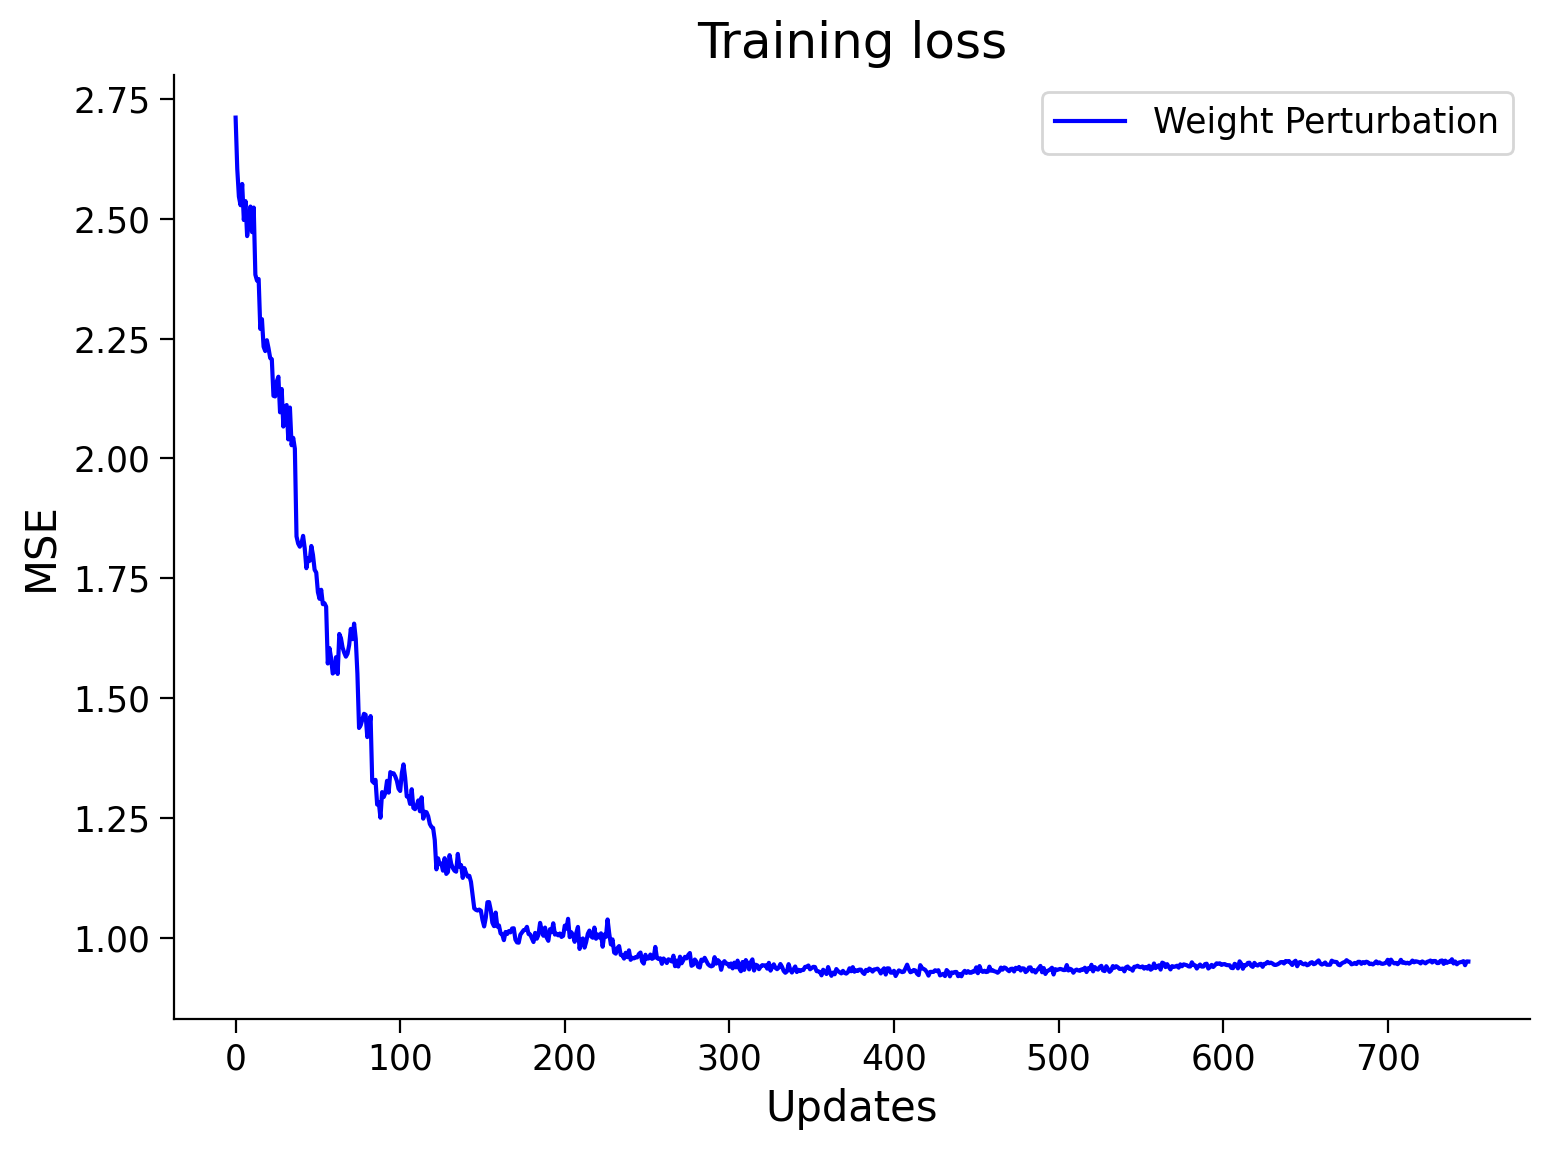

In [12]:
# Create and train a WeightPerturbMLP
rng_wp = np.random.default_rng(seed=seed)

losses_perturb = np.zeros((numupdates,))
accuracy_perturb = np.zeros((numepochs,))

# select 1000 random images to test the accuracy on
indices = rng_wp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using weight perturbation
netperturb = WeightPerturbMLP(rng_wp, numhidden, sigma=initweight, activation=activation)
(losses_perturb[:], accuracy_perturb[:], _, snr_perturb) = \
    netperturb.train(rng_wp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                     learning_rate=learnrate, batch_size=batchsize, algorithm='perturb', noise=noise, \
                     report=report, report_rate=rep_rate)

# plot performance over time
plt.plot(losses_perturb, label="Weight Perturbation", color='b')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()


# Section 2: Node Perturbation

While we can get an unbiased derivative approximation based solely on perturbations of the weights, we will show later on that this is actually a very inefficient method, because it requires averaging out $N^2$ noise sources, where $N$ is the dimension of $\rate$. Alternatively, if we add noise at the level of the units $\rate$, we will only have to average over $N$ noise sources. To do this, we can use the following update, taking $\rate' = \rate + \noiser$, where $\noiser \sim \mathcal{N}(0,\sigma^2)$:

\begin{equation}
    \Delta \weight =  - \eta \mathbb{E}_{\noiser} \left [\left(\loss(\noiser) - \loss(0) \right ) \frac{(\rate' - \rate)}{\sigma^2} \stim\T \right ].
\end{equation}
We will now show why this update is interesting from a neuroscience perspective (for much the same reason as for weight perturbation). For a single synapse, the approximate update using samples of $\noiser$ is given by:
\begin{equation}
    \Delta \weight_{ij} \approx - \eta \frac{1}{K} \sum_{k=0}^{K} \left [\left(\loss(\noiser^{(k)}) - \loss(0) \right ) \frac{(\rate'^{(k)}_i - \rate_i)}{\sigma^2} \stim_j \right ].
\end{equation}
Once again this update requires very little knowledge about the rest of the neural circuit in order for a synapse to compute it. It requires knowledge of the global loss, $\loss(\noiser^{(k)})$, postsynaptic activity $\rate^{(k)}_i$, and presynaptic activity $\stim_j$. This form of parameter update is often called a Reward (loss)-modulated Hebbian plasticity rule, or a 3-factor plasticity rule.

To show that this update is unbiased, we again employ a Taylor expansion: $\loss(\noiser) \approx \loss(0) + \derivative{\loss}{\rate}\T\noiser$, to get:
\begin{align}
    \Delta \weight_{ij} &=  - \eta \mathbb{E}_{\noiser} \left [\left(\derivative{\loss}{\rate}\T\noiser \right ) \frac{\noiser_i}{\sigma^2} \stim_j \right ] \\
    &=  - \eta \pderivative{\loss}{\rate_i} \stim_j \\
    &=  - \eta \pderivative{\loss}{\rate_i} \pderivative{\rate_i}{\weight_{ij}}\\
    &=  - \eta \pderivative{\loss}{\weight_{ij}},
\end{align}
Where the second equality follows from the fact that $\mathbb{E}_{\noiser} \left [ \noiser_i \noiser_k \right ] = \sigma^2$ if and only if $i = k$, and is 0 otherwise. This analysis shows that we can estimate derivatives by correlating fluctuations in either $\weight$ *or* $\rate$ with fluctuations in the loss function. Neither strategy requires evaluating derivatives of $\blackbox(\cdot)$, they only require some extrinsic measure of performance, given by $\mathcal{L}$ and how performance varies in response to perturbations in either weights or nodes, respectively. In subsequent sections, we will investigate how these different methods compare in terms of their ability to estimate gradients in systems with large numbers of neurons. We will show that there is no free lunch--though these methods require less information, they are less *efficient* than analytic gradient calculations.

In [13]:
class NodePerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through node perturbation
    """

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """

        # get the random perturbations
        hidden, output = self.inference(rng, inputs)
        hidden_p, output_p = self.inference(rng, inputs, noise=noise)

        loss_now = self.mse_loss_batch(rng, inputs, targets, output=output)
        loss_per = self.mse_loss_batch(rng, inputs, targets, output=output_p)
        delta_loss = loss_now - loss_per

        hidden_update = np.mean(
            delta_loss * (((hidden_p - hidden) / noise ** 2)[:, None, :] * add_bias(inputs)[None, :, :]), axis=2)
        output_update = np.mean(
            delta_loss * (((output_p - output) / noise ** 2)[:, None, :] * add_bias(hidden_p)[None, :, :]), axis=2)

        return (hidden_update, output_update)


Training starting...
...completed  1  epochs of training. Current loss:  0.89 .
...completed  2  epochs of training. Current loss:  0.85 .
...completed  3  epochs of training. Current loss:  0.81 .
Training complete.


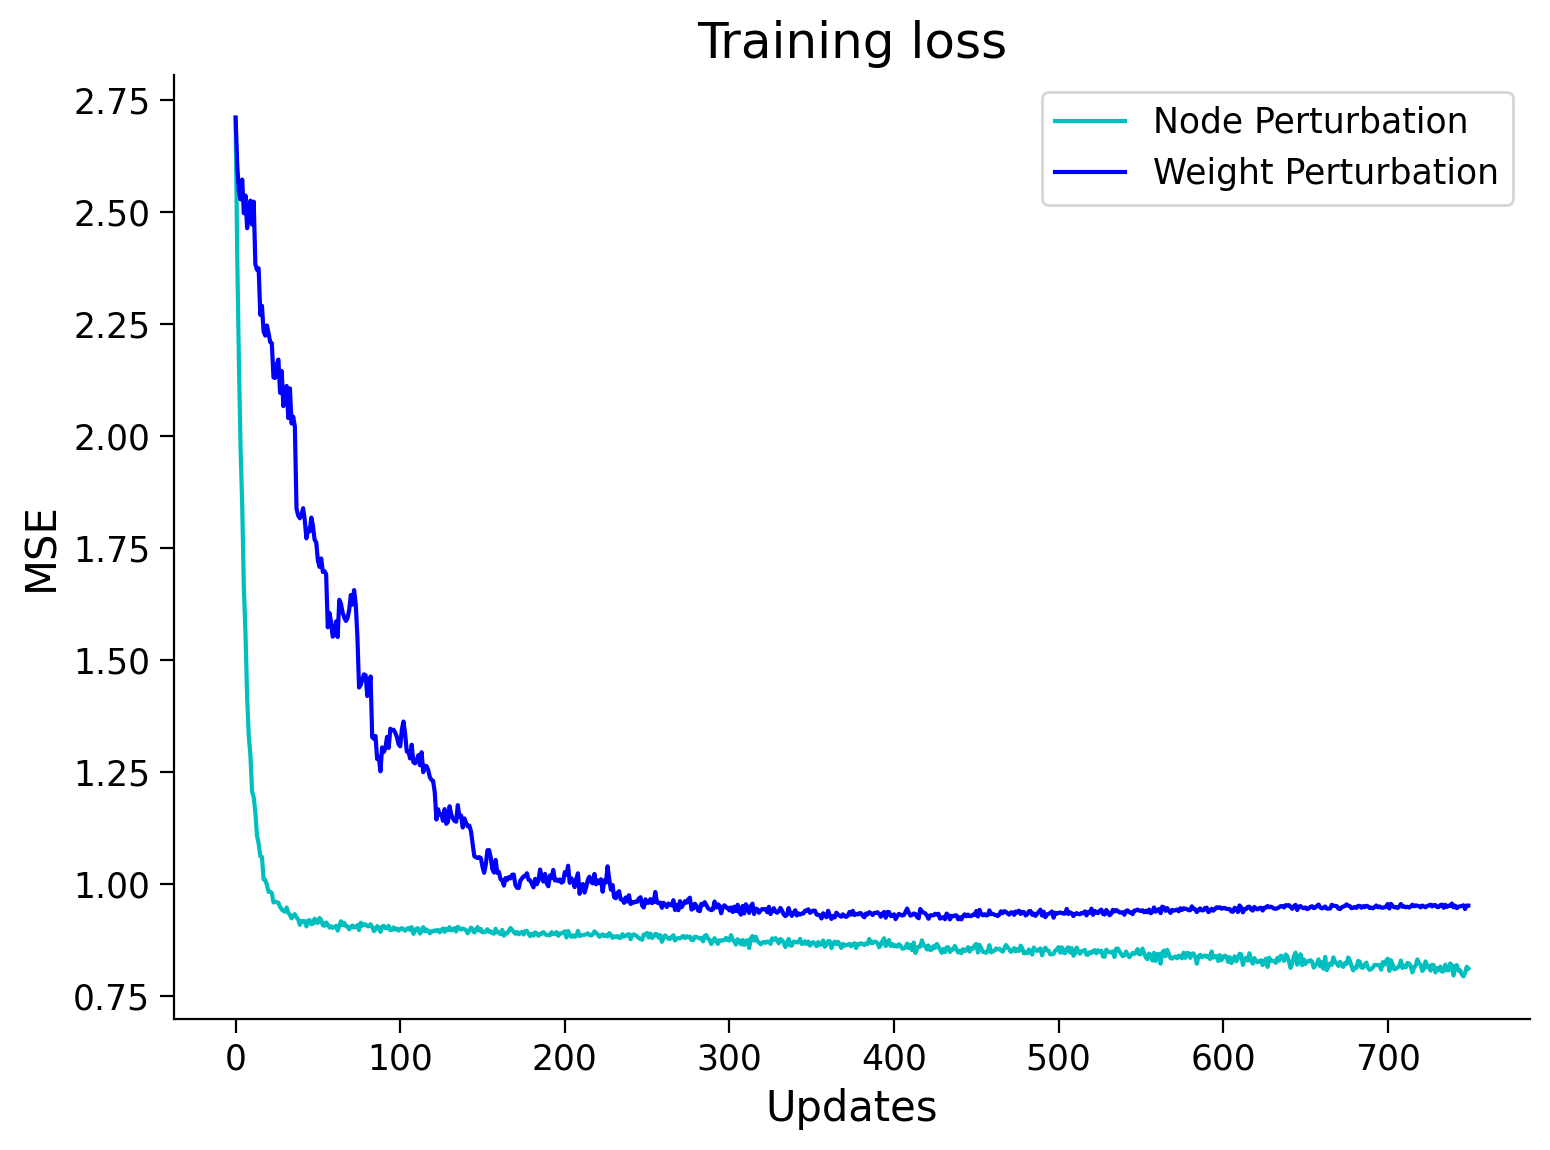

Start Time: 1713292839.33998 seconds
End Time: 1713293114.86865 seconds
Elapsed Time: 275.52867 seconds


In [14]:
# Create and train a NodePerturbMLP network
import time

# Record the start time
start_time = time.time()

losses_node_perturb = np.zeros((numupdates,))
accuracy_node_perturb = np.zeros((numepochs,))

# set the random seed
rng_np = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_np.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using weight perturbation
netnodeperturb = NodePerturbMLP(rng_np, numhidden, sigma=initweight, activation=activation)
(losses_node_perturb[:], accuracy_node_perturb[:], _, snr_node_perturb) = \
    netnodeperturb.train(rng_np, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                         learning_rate=learnrate, batch_size=batchsize, algorithm='node_perturb', noise=noise, \
                         report=report, report_rate=rep_rate)

# plot performance over time
plt.plot(losses_node_perturb, label="Node Perturbation", color='c')
plt.plot(losses_perturb, label="Weight Perturbation", color='b')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

# Record the end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Print the results
print("Start Time: {:.5f} seconds".format(start_time))
print("End Time: {:.5f} seconds".format(end_time))
print("Elapsed Time: {:.5f} seconds".format(elapsed_time))


# Section 3: Assessing the variance of learning algorithms

$\newcommand{\stim}{\mathbf{x}}$
$\newcommand{\noisew}{\boldsymbol \Psi}$
$\newcommand{\noiser}{\boldsymbol \xi}$
$\newcommand{\target}{y}$
$\newcommand{\targetdim}{\mathbf{y}}$
$\newcommand{\identity}{\mathbf{I}}$
$\newcommand{\blackbox}{f}$
$\newcommand{\weight}{\mathbf{W}}$
$\newcommand{\loss}{\mathcal{L}}$
$\newcommand{\derivative}[2]{\frac{d#1}{d#2}}$
$\newcommand{\rate}{\mathbf{r}}$
$\newcommand{\T}{^{\top}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}\,}$
$\newcommand{\brackets}[1]{\left(#1\right)}$
$\newcommand{\sqbrackets}[1]{\left[#1\right]}$
$\newcommand{\var}[1]{\mathbb{V}\mathrm{ar}\brackets{#1}}$
ADD VIDEO

The main issue of perturbation methods is noise. Here we will show that analytically for a simplified loss and network. First, we will work with a linear network so $\widehat\targetdim =\weight\stim$, where $\widehat\targetdim\in\RR^M$, $\weight\in\RR^{M\times N}$ and $\stim\in\RR^N$. Second, we will assume that the target output is zero $\targetdim=0$, so the loss  becomes $\loss(\weight)=\frac{1}{2}\|\weight\stim\|^2_2$. (This is equivalent to saying that $\targetdim=\weight^*\stim$ and then shifting the actual weights to be $\weight - \weight^*$.)


With these changes, we will compute the variance of weight updates for a given input $\stim$, i.e.
\begin{equation*}
    \var{\Delta \weight}=\EE\brackets{\Delta \weight - \EE\Delta\weight}^2 = \EE\brackets{\Delta \weight}^2 - \brackets{\EE\Delta\weight}^2\,.
\end{equation*}
We already know that the $\EE\Delta\weight$ is the gradient update, so
\begin{equation}
   \brackets{\EE\Delta\weight_{ij}}^2 =  \eta^2  \brackets{\derivative{\loss}{\weight}}_{ij}^2.
\end{equation}

Therefore we only need to compute $\EE(\Delta\weight)^2$ for both algorithms.

**Weight perturbation** For a single weight $\weight_{ij}$, we can use the approximate weight change:
\begin{align}
    \Delta \weight_{ij} \,&=  - \eta \sum_{kl} \brackets{\brackets{\derivative{\loss}{\weight}}_{kl} \noisew_{kl}} \frac{\noisew_{ij}}{\sigma^2}\,,\\
    \brackets{\Delta \weight_{ij}}^2 \,&=  \frac{\eta^2}{\sigma^4} \brackets{\sum_{kl}\brackets{\derivative{\loss}{\weight}}_{kl} \noisew_{kl}}^2 \noisew_{ij}^2\\
    &=\frac{\eta^2}{\sigma^4} \brackets{\sum_{kldn}\brackets{\derivative{\loss}{\weight}}_{kl}\brackets{\derivative{\loss}{\weight}}_{dn} \noisew_{kl}\noisew_{dn}} \noisew_{ij}^2\,.
\end{align}

Now we can take the expectation of the last line w.r.t. the noise $\noisew$. Since all entries of the noise matrix are independent and zero-mean, we will have non-zero terms in two case: $kl=dn\neq ij$ and $kl=dn=ij$:
\begin{align}
    \EE\noisew_{kl}\noisew_{dn}\noisew_{ij}^2 = \begin{cases}
        0 & k \neq d\ \mathrm{or}\ l\neq n\\
        \sigma^4 & k=d, l=n, (k\neq i\ \mathrm{or}\ l\neq j)\\
        3\,\sigma^4 & k=d=i,l=n=j
    \end{cases}
\end{align}

Therefore,
\begin{align}
    \EE_{\noisew}\brackets{\brackets{\Delta \weight_{ij}}^2} \,& = \frac{\eta^2}{\sigma^4}  \brackets{\derivative{\loss}{\weight}}_{ij}^2 \EE \noisew_{ij}^4 + \frac{\eta^2}{\sigma^4} \sum_{kl\neq ij} \brackets{\derivative{\loss}{\weight}}_{kl}^2 \EE\brackets{\noisew_{kl}^2 \noisew_{ij}^2}\\
    &=3\eta^2  \brackets{\derivative{\loss}{\weight}}_{ij}^2 + \eta^2\sum_{kl\neq ij} \brackets{\derivative{\loss}{\weight}}_{kl}^2\,,
\end{align}

where we used that the 4th central of the Gaussian $\EE \noisew_{ij}^4=3\sigma^4$.

Using the above result, we arrive at
\begin{align}
    \var{\Delta \weight_{ij}} = \eta^2  \brackets{\derivative{\loss}{\weight}}_{ij}^2 + \eta^2\sum_{kl} \brackets{\derivative{\loss}{\weight}}_{kl}^2 = O(MN)\,,
\end{align}
where the scaling comes from having $MN$ terms in the sum.

**Node perturbation** Again, for a single weight $\weight_{ij}$, we can use the approximate weight change:
\begin{align}
    \Delta \weight_{ij} \,&= -\frac{\eta}{\sigma^2}\brackets{\sum_{k}\brackets{\derivative{\loss}{\rate}}_k\noiser_k} \noiser_i\stim_j\,,\\
    \brackets{\Delta \weight_{ij}}^2 \,&= \frac{\eta^2}{\sigma^4}\brackets{\sum_{k}\brackets{\derivative{\loss}{\rate}}_k\noiser_k}^2 \noiser_i^2\stim_j^2\\
    &=\frac{\eta^2}{\sigma^4}\brackets{\sum_{k}\brackets{\derivative{\loss}{\rate}}_k\brackets{\derivative{\loss}{\rate}}_d\noiser_k\noiser_d} \noiser_i^2\stim_j^2\,.
\end{align}

Again, computing the expectation over the last line will make use of the independent zero-mean Gaussian noise:
\begin{align}
    \EE\noiser_k\noiser_d\noiser_i^2 = \begin{cases}
        0 & k \neq d\\
        \sigma^4 & k=d\neq i\\
        3\,\sigma^4 & k=d=i
    \end{cases}
\end{align}

Since only $k=d\neq i$ and $k=d=i$ terms will remain non-zero, we obtain
\begin{align}
    \EE_{\noiser}\brackets{\brackets{\Delta \weight_{ij}}^2} \,&= \frac{\eta^2}{\sigma^4}\brackets{\derivative{\loss}{\rate}}_i^2 \EE\brackets{\noiser_i^4}\stim_j^2 + \frac{\eta^2}{\sigma^4}\brackets{\sum_{k\neq i}\brackets{\derivative{\loss}{\rate}}_k^2\EE\brackets{\noiser_k^2 \noiser_i^2}\stim_j^2}\\
    &=3 \eta^2\brackets{\derivative{\loss}{\rate}}_i^2 \stim_j^2 + \eta^2\sum_{k\neq i}\brackets{\derivative{\loss}{\rate}}_k^2\stim_j^2\,.
\end{align}

Now since $\brackets{\EE_{\noiser}\Delta \weight_{ij}}^2=\eta^2\brackets{\derivative{\loss}{\rate}}_i^2 \stim_j^2$, we have
\begin{equation}
    \var{\Delta \weight_{ij}} = \eta^2\brackets{\derivative{\loss}{\rate}}_i^2 \stim_j^2 + \eta^2\sum_{k}\brackets{\derivative{\loss}{\rate}}_k^2\stim_j^2 = O(M)\,,
\end{equation}
where the scaling comes from the sum over $M$ outputs.

EXPLAIN SNR

Training starting...
...completed  1  epochs of training. Current loss:  0.41 .
...completed  2  epochs of training. Current loss:  0.32 .
...completed  3  epochs of training. Current loss:  0.28 .
Training complete.


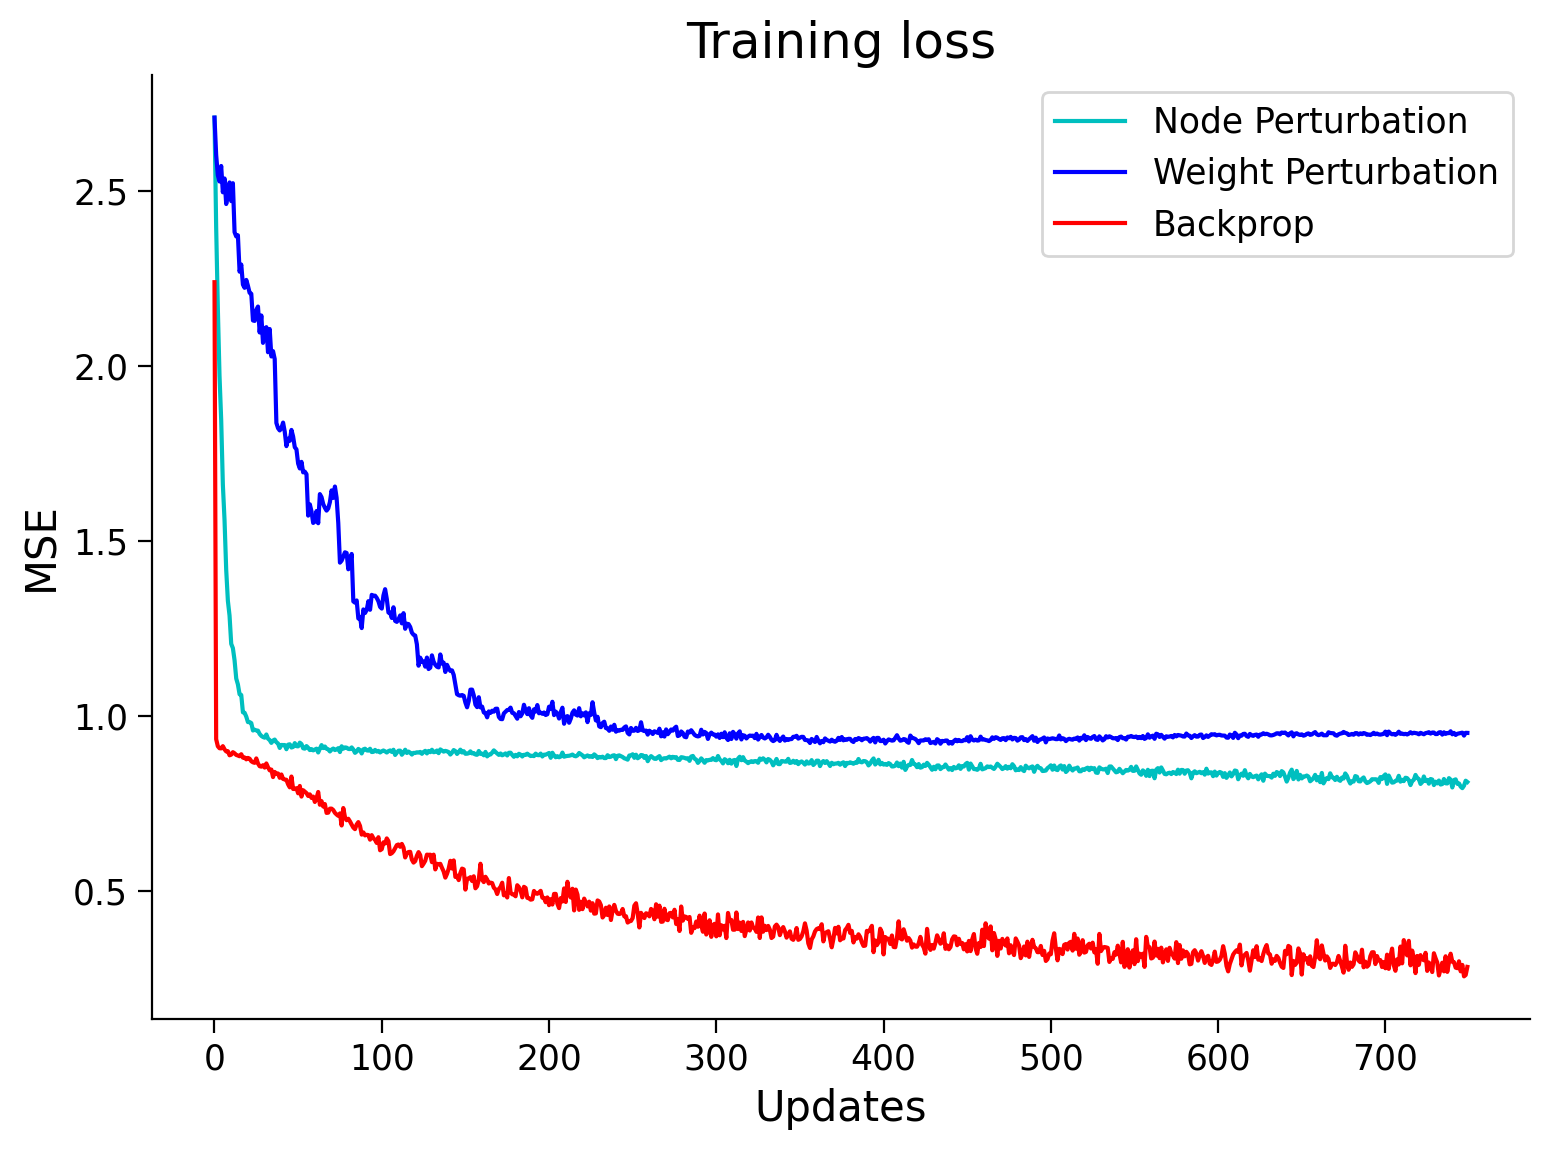

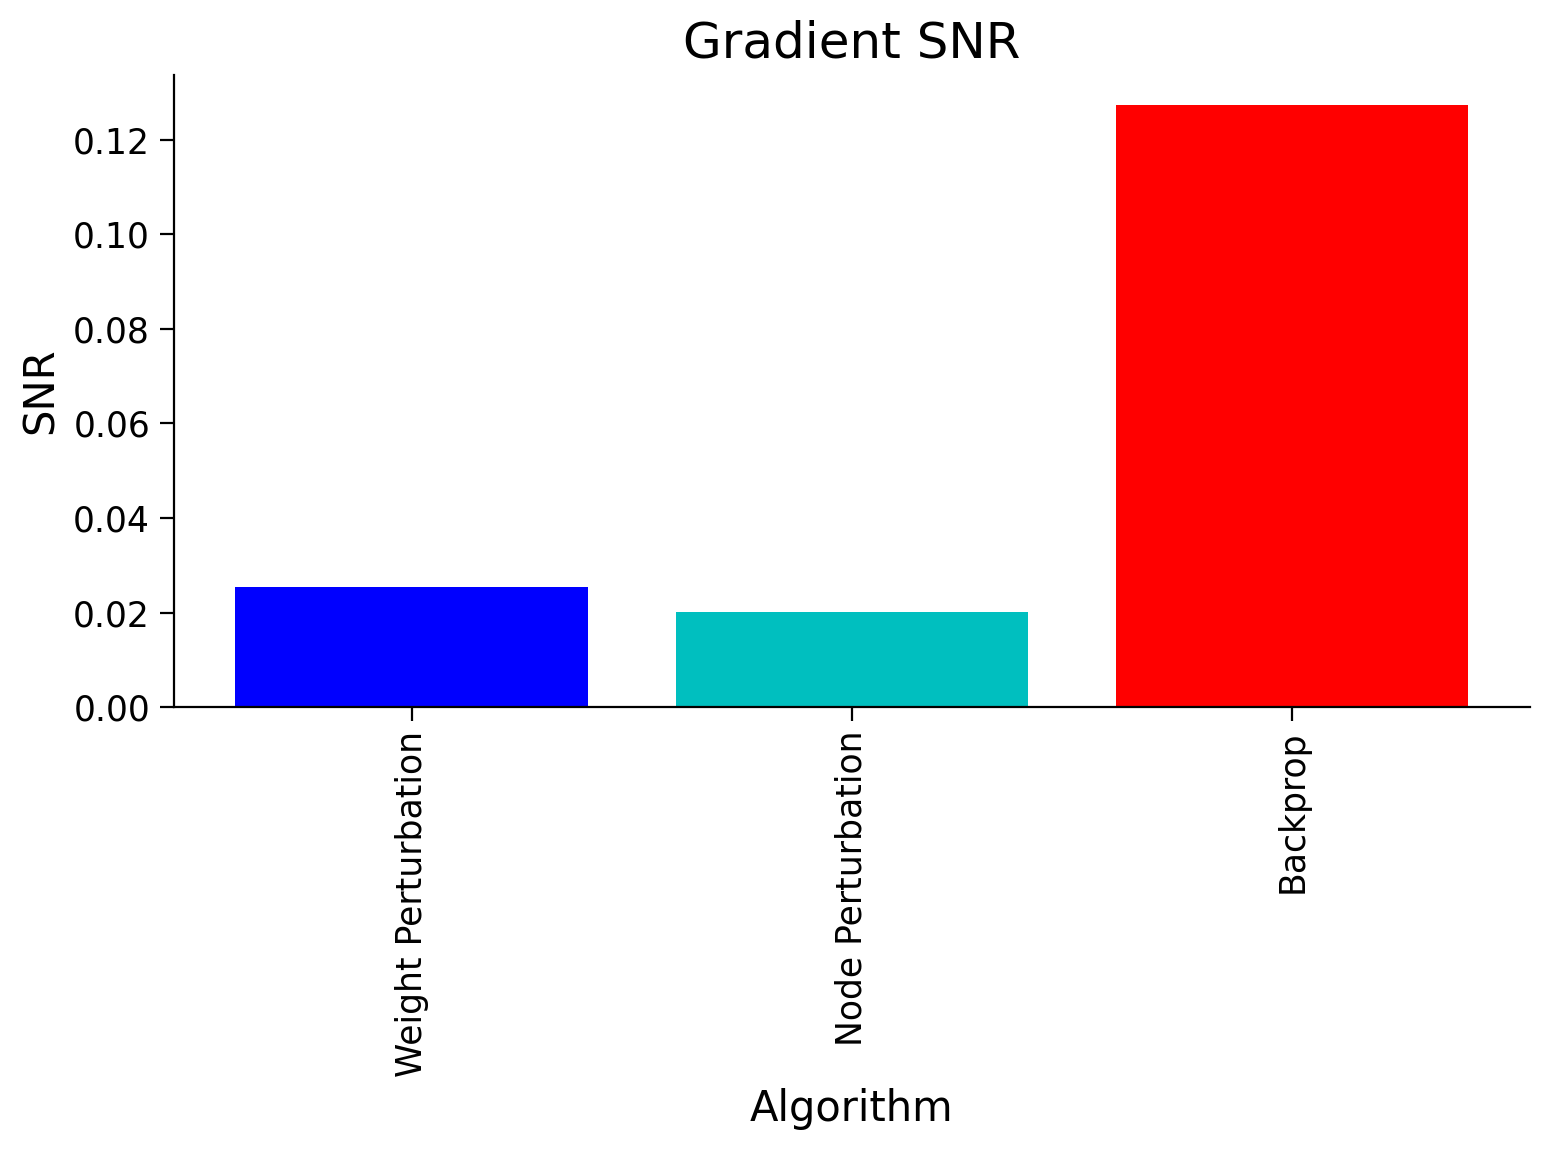

In [15]:
# Compare the SNRs for Weight Perturbation, Node Perturbation, and Backpropagation

# initialize the loss and accuracy holders
losses_backprop = np.zeros((numupdates,))
accuracy_backprop = np.zeros((numepochs,))

# First, we have to train a network with Backpropagation for comparison

# set the random seed to the current time
rng_bp = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_bp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using backprop
netbackprop = MLP(rng_np, numhidden, sigma=initweight, activation=activation)
(losses_backprop[:], accuracy_backprop[:], _, snr_backprop) = \
    netbackprop.train(rng_bp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

# plot performance over time
plt.plot(losses_node_perturb, label="Node Perturbation", color='c')
plt.plot(losses_perturb, label="Weight Perturbation", color='b')
plt.plot(losses_backprop, label="Backprop", color='r')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

# plot the SNR at initialization for the three learning algorithms
plt.figure()
x = [0, 1, 2]
snr_vals = [snr_perturb, snr_node_perturb, snr_backprop]
colors = ['b', 'c', 'r']
labels = ['Weight Perturbation', 'Node Perturbation', 'Backprop']
plt.bar(x, snr_vals, color=colors, tick_label=labels)
plt.xticks(rotation=90)
plt.ylabel('SNR')
plt.xlabel('Algorithm')
plt.title('Gradient SNR')
plt.show()


# Section 4: Feedback Alignment 

INSERT JONNY'S VIDEO HERE

$\newcommand{\stim}{\mathbf{x}}$
$\newcommand{\h}{\mathbf{h}}$
$\newcommand{\noisew}{\boldsymbol \Psi}$
$\newcommand{\noiser}{\boldsymbol \xi}$
$\newcommand{\target}{y}$
$\newcommand{\pred}{\mathbf{\hat{y}}}$
$\newcommand{\identity}{\mathbf{I}}$
$\newcommand{\blackbox}{f}$
$\newcommand{\weight}{\mathbf{W}}$
$\newcommand{\weightout}{\mathbf{W}^{\textrm{out}}}$
$\newcommand{\loss}{\mathcal{L}}$
$\newcommand{\derivative}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\rate}{\mathbf{r}}$
$\newcommand{\error}{\boldsymbol \delta}$
$\newcommand{\losserror}{\mathbf{e}}$
$\newcommand{\backweight}{\mathbf{B}}$

We assume the following network setup:

\begin{align}
    \pred = \blackbox(\weight \stim) = \weightout\sigma(\weight\stim) =\weightout \h
\end{align}

With a mean squared error loss over all of the output neurons.
\begin{equation}
    \loss = \frac{1}{2n} \sum_{k=1}^{n}\left (\target_k - \hat{y}_k \right )^2
\end{equation}

Note here we have suppressed the batch index notation, and will calculate the following gradients as averages over batch elements.

Backpropagation updates parameters using the gradient of the loss scaled by the learning rate $\eta$.

\begin{align}
    \Delta \weight_{ji} &= - \eta \derivative{\loss}{\weight}_{ji} \\
    &= - \eta \underbrace{\derivative{\loss}{\pred}\derivative{\pred}{h_j}}_{\delta_j}\derivative{h_j}{\weight_{ji}}\\
    &= - \eta \delta_j \sigma^{\prime}(\weight\stim)_j\stim_i \\
    &= - \eta \delta_j h^{\prime}_j\stim_i
\end{align}

While $h^{\prime}_j$ and $\stim_i$ are available locally to the neuron, calculating $\delta_j$
involves non-local information, and is therefore biologically implausbile.

\begin{align}
    \delta_j &= \derivative{\loss}{h_j} \\
    &= \sum_{k=1}^n \derivative{\loss}{\hat{y}_k}\derivative{\hat{y}_k}{h_j} \\
    &= \sum_{k=1}^n \overbrace{(y_k - \hat{y_k})}^{e_k} \weightout_{kj} \\
    &= e_1 {\color{red}\weightout_{1j}} + e_2 {\color{green}\weightout_{2j}} + e_3{\color{magenta}\weightout_{3j}}
\end{align}

In order to calculate $\delta_j$ we need to use all of of the outgoing weights from neuron $h_j$.

Writing $\error$ as a column vector (i.e. $\derivative{\loss}{\h}$ in  \href{https://en.wikipedia.org/wiki/Matrix_calculus#Layout_conventions}{denominator layout}) we see that in order to calcuate $\error$ we need the transpose of the forward weights.
\begin{align}
    \error &= \weight_{out}^T \losserror .
\end{align}

Feedback alignment replaces $\weight_{out}^T $ with a random matrix, $\backweight$.

## Exercise 2: fill-in-the-blank

In [16]:
class FeedbackAlignmentMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Feedback Alignment algorithm
    """

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: calculate the updates")
        ###################################################################
        
        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the updates
        error = ...
        delta_W_h = np.dot(np.dot(self.V, error * self.act_deriv(output)) * self.act_deriv(hidden),
                           add_bias(inputs).transpose())
        delta_W_y = ...

        return delta_W_h, delta_W_y


In [ ]:
# to remove solution

class FeedbackAlignmentMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Feedback Alignment algorithm
    """

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """

        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the updates
        error = targets - output
        delta_W_h = np.dot(np.dot(self.V, error * self.act_deriv(output)) * self.act_deriv(hidden),
                           add_bias(inputs).transpose())
        delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())

        return delta_W_h, delta_W_y


In [17]:
# run parameters
numhidden  = 500
batchsize  = 200
initweight = 0.1
learnrate  = 0.001
noise      = 0.1
numepochs  = 3
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report     = True
rep_rate   = 1
# set the random seed to the current time
seed = 12345 #int(round(datetime.now().timestamp()))

Training starting...
...completed  1  epochs of training. Current loss:  0.58 .
...completed  2  epochs of training. Current loss:  0.41 .
...completed  3  epochs of training. Current loss:  0.34 .
Training complete.
Training starting...
...completed  1  epochs of training. Current loss:  0.43 .
...completed  2  epochs of training. Current loss:  0.32 .
...completed  3  epochs of training. Current loss:  0.27 .
Training complete.


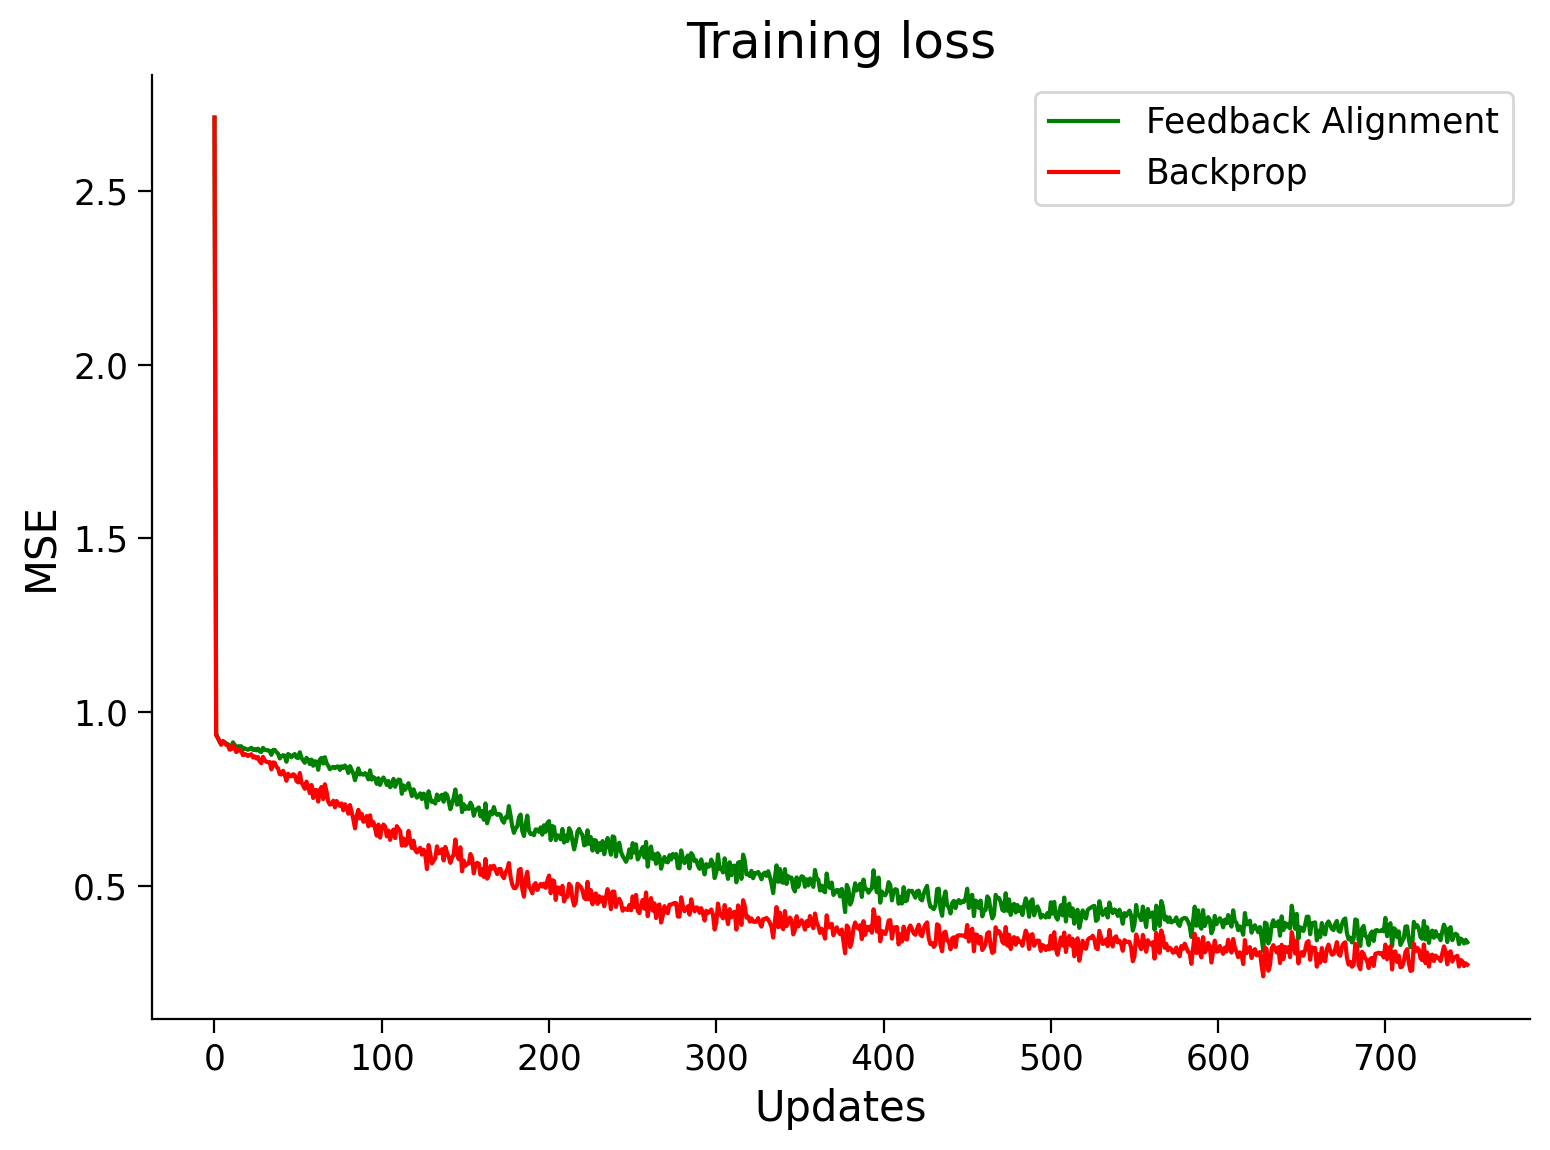

In [18]:
# Create and train a FeedbackAlignmentMLP
rng_fa = np.random.default_rng(seed=seed)

losses_feedback = np.zeros((numupdates,))
accuracy_feedback = np.zeros((numepochs,))
cosine_sim_feedback = np.zeros((numepochs,))

# select 1000 random images to test the accuracy on
indices = rng_fa.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using feedback alignment
netfeedback = FeedbackAlignmentMLP(rng_fa, numhidden, sigma=initweight, activation=activation)
(losses_feedback[:], accuracy_feedback[:], cosine_sim_feedback[:], _) = \
    netfeedback.train(rng_fa, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='feedback', noise=noise, \
                      report=report, report_rate=rep_rate)

# Train a network with Backpropagation for comparison

# set the random seed to the current time
rng_bp2 = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_bp2.choice(range(test_images.shape[1]), size=(1000,), replace=False)

losses_backprop = np.zeros((numupdates,))
accuracy_backprop = np.zeros((numepochs,))
cosine_sim_backprop = np.zeros((numepochs,))

# create a network and train it using backprop
netbackprop = MLP(rng_bp2, numhidden, sigma=initweight, activation=activation)
(losses_backprop[:], accuracy_backprop[:], cosine_sim_backprop, _) = \
    netbackprop.train(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

# plot performance over time
plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(losses_backprop, label="Backprop", color='r')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()


# Section 5: Kolen-Pollack

INSERT DAN'S VIDEO HERE

$\newcommand{\error}{\boldsymbol \delta}$
$\newcommand{\losserror}{\mathbf{e}}$
$\newcommand{\backweight}{\mathbf{B}}$
$\newcommand{\h}{\mathbf{h}}$
$\newcommand{\y}{\mathbf{y}}$


As we've just seen, to update a feed-forward matrix using back-propagated error, we need to simply follow the weight update equation:
\begin{align}
    %\Delta \weight_{ji} &= - \eta \delta_j h^{\prime}_j\stim_i \\
    \Delta \weight_{out} &= - \eta \losserror \h^T \\
    \Delta \weight &= - \eta (\error \h^{\prime})\stim^T,
\end{align}
where
\begin{align}
    \error &= \weight_{out}^T \losserror .
\end{align}
While directly "transporting" the weights, $\weight_{out}^T$, is not biologically plausible, we showed that a random feedback matrix, $\backweight$, can align the weights to propagate an approximated error,
\begin{align}
    \error &= \backweight \losserror .
\end{align}

However, this approach fails with deeper networks and more complicated datasets. We will now show a biologically plausible approach to modifying $\backweight$, such that over learning, $\backweight$ and $ \weight_{out}^T $ become equal. This approach builds off an observation by Kolen and Pollack (1994) that if two matrices are repeatedly modified by the same values with weight decay,

\begin{align}
    \Delta \weight(t) &= \mathbf{A}(t) - \lambda \weight(t) \\
    \Delta \backweight(t) &= \mathbf{A}(t) - \lambda \backweight(t) ,
\end{align}
then
\begin{align}
    \weight(t+1) - \backweight(t+1) &= \weight(t) + \Delta \weight(t) - \backweight(t) - \Delta \backweight(t) \\
    &= \weight(t) - \backweight(t) - \lambda[\weight(t) - \backweight(t)] \\
    &= (1-\lambda)^{t+1} [\weight(0) - \backweight(0)] .
\end{align}
That is, as $t \rightarrow \infty$, the difference between the two matrices will converge to 0.

The key observation is that the corresponding elements of $\weight_{out}^T$ and $ \backweight $ have access to the same locally available information. We can thus pick a plausible learning rule for the backward weights:

\begin{align}
    \Delta \backweight &= - \eta \h \losserror^T - \lambda \backweight ,
\end{align}
such that the updates to $\backweight$ correspond to a transpose of the updates to $\weight_{out}$,
\begin{align}
    \Delta \weight_{out} &= - \eta \losserror \h^T - \lambda \weight_{out} \\
    \Delta \weight_{out}^T &= - \eta \h \losserror^T - \lambda \weight_{out}^T.
\end{align}

Thus, over many weight updates, $ \backweight $ will converge to $\weight_{out}^T$ and can be used to propagate errors back to inform updates to $\weight$. Note that the same reasoning can be applied to networks of many layers.

# Exercise 3: fill-in-the-blank

In [19]:
class KolenPollackMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Kolen-Pollack algorithm
    """

    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: calculate updates.")
        ###################################################################

        # do a forward pass
        (hidden, output) = self.inference(rng, inputs)

        # calculate the updates for the forward weights
        error = targets - output
        delta_W_h = np.dot(np.dot(self.V, error * self.act_deriv(output)) * self.act_deriv(hidden), \
                           add_bias(inputs).transpose())
        delta_err = ...
        delta_W_y = delta_err - 0.1 * self.W_y

        # calculate the updates for the backwards weights and implement them
        delta_V = delta_err[:, :-1].transpose() - 0.1 * self.V
        self.V += ...
        return (delta_W_h, delta_W_y)


In [ ]:
# to remove solution

class KolenPollackMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Kolen-Pollack algorithm
    """

    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """

        # do a forward pass
        (hidden, output) = self.inference(rng, inputs)

        # calculate the updates for the forward weights
        error = targets - output
        delta_W_h = np.dot(np.dot(self.V, error * self.act_deriv(output)) * self.act_deriv(hidden), \
                           add_bias(inputs).transpose())
        delta_err = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())
        delta_W_y = delta_err - 0.1 * self.W_y

        # calculate the updates for the backwards weights and implement them
        delta_V = delta_err[:, :-1].transpose() - 0.1 * self.V
        self.V += eta_back * delta_V
        return (delta_W_h, delta_W_y)


Training starting...
...completed  1  epochs of training. Current loss:  0.56 .
...completed  2  epochs of training. Current loss:  0.38 .
...completed  3  epochs of training. Current loss:  0.31 .
Training complete.


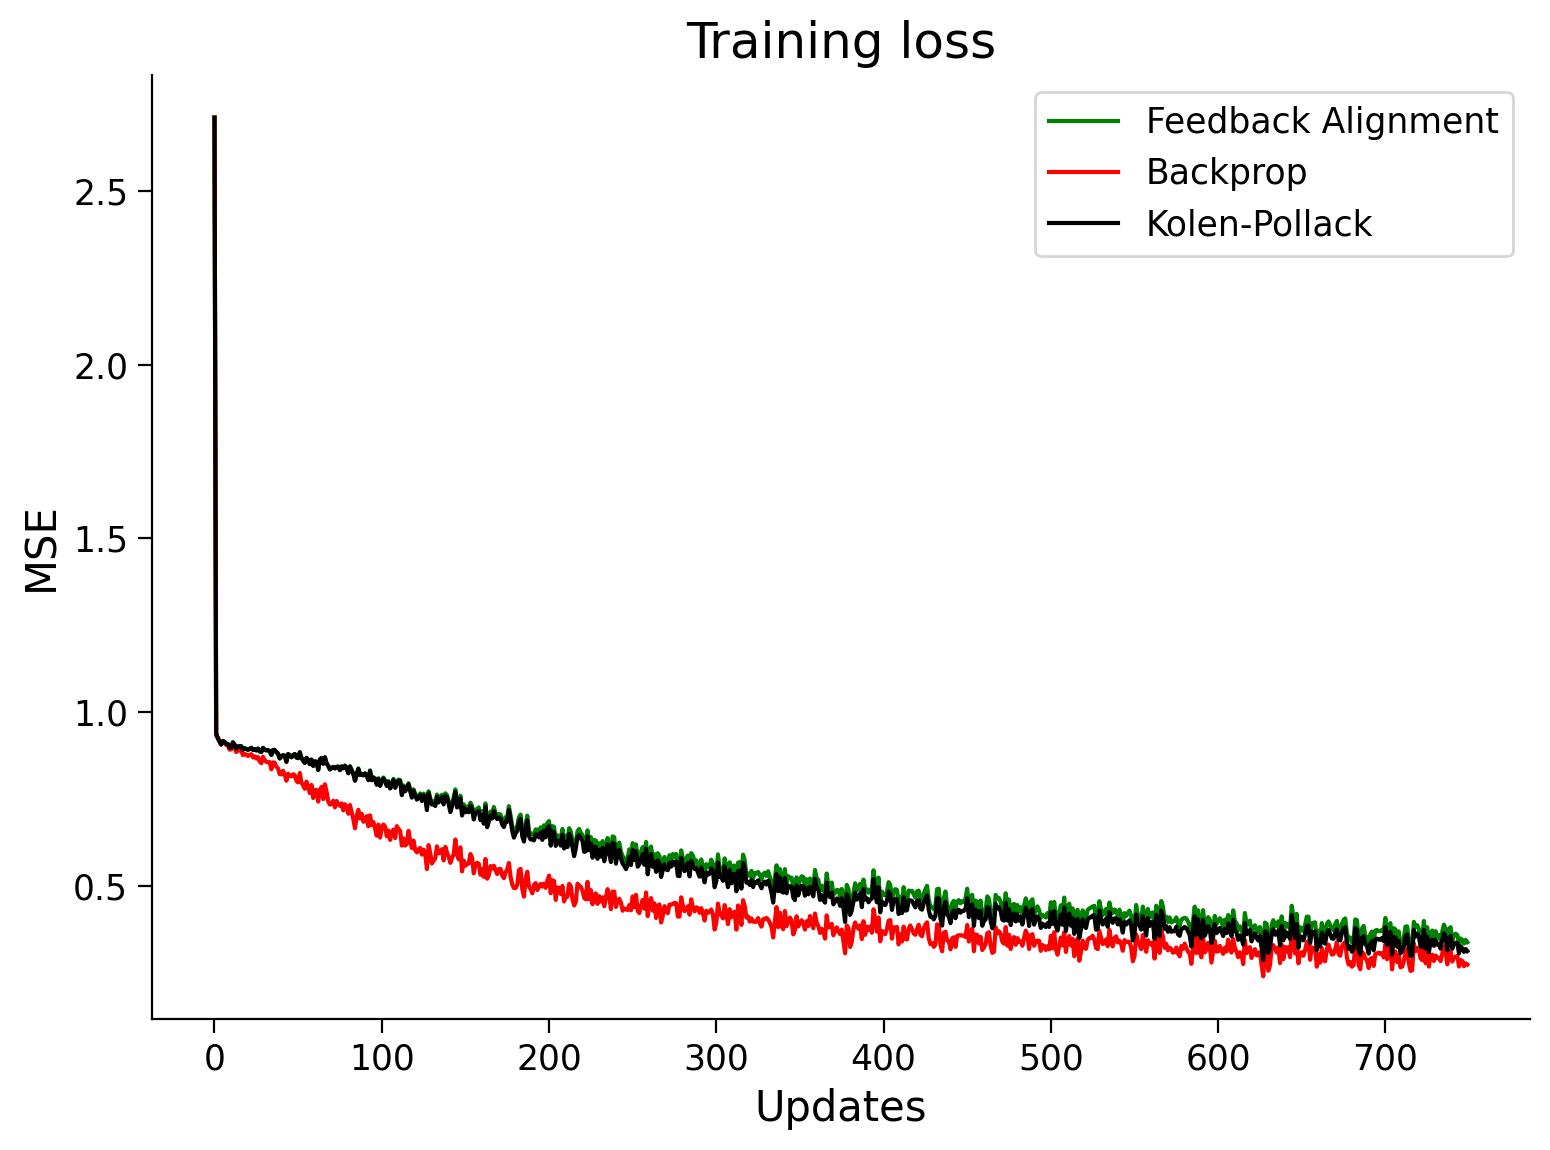

In [20]:
# Create and train a KolenPollackMLP
rng_kp = np.random.default_rng(seed=seed)

losses_kolepoll = np.zeros((numupdates,))
accuracy_kolepoll = np.zeros((numepochs,))
cosine_sim_kolepoll = np.zeros((numepochs,))
# select 1000 random images to test the accuracy on
indices = rng_kp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using feedback alignment
netkolepoll = KolenPollackMLP(rng_kp, numhidden, sigma=initweight, activation=activation)
(losses_kolepoll[:], accuracy_kolepoll[:], cosine_sim_kolepoll[:], _) = \
    netkolepoll.train(rng_kp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=rep_rate)

# plot performance over time
plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(losses_backprop, label="Backprop", color='r')
plt.plot(losses_kolepoll, label="Kolen-Pollack", color='k')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()


# Section 5: Assessing the bias of learning algorithms

EXPLAIN COSINE SIMILARITY HERE

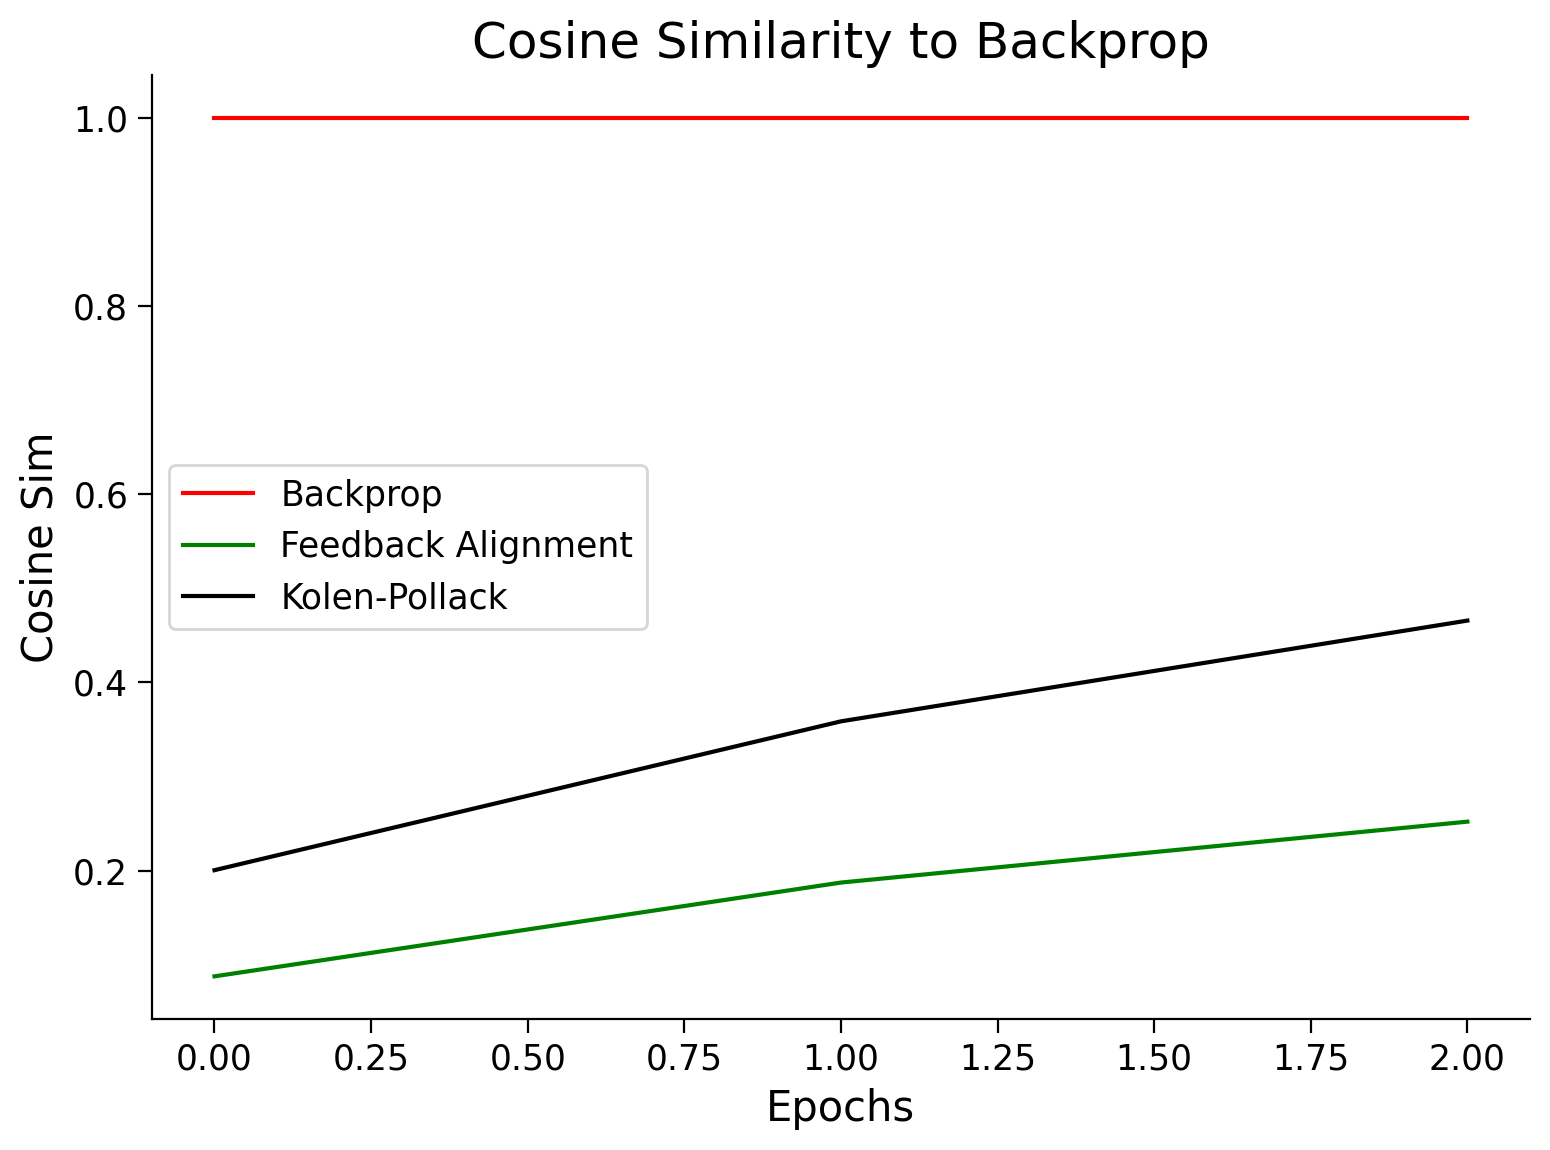

In [21]:
# Plot the gradient similarity to backprop over training with shaded error regions
plt.plot(cosine_sim_backprop, label="Backprop", color='r')
plt.plot(cosine_sim_feedback, label="Feedback Alignment", color='g')
plt.plot(cosine_sim_kolepoll, label="Kolen-Pollack", color='k')
plt.xlabel("Epochs")
plt.ylabel("Cosine Sim")
plt.legend()
plt.title("Cosine Similarity to Backprop")
plt.show()
